In [1]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
def MAF(x,window):
    new_signals = np.zeros(x.shape)
    sample_num, T = x.shape
    for i in range(sample_num):
      noise = np.convolve(x[i], np.ones(window),'same')/window
      new_signals[i] = x[i] - noise
   
    return new_signals


def asln(x,a,b):

    C,T = x.shape
    noise = a*np.linspace(0,1,T) - b*np.ones(T)
    noise = noise*np.ones((C,1))
    n = np.random.randint(2)
    if n == 0:
      new_signals = x + noise
    else:
      new_signals = x - noise
    return new_signals

def apn(x,c,d):
    C,T = x.shape
    noise = np.linspace(-np.pi+d,np.pi+d,T) - d*np.ones(T)
    noise = c*np.sin(noise)*np.ones((C,1))
    new_signals = x + noise
    return new_signals

In [4]:
def augmented_data(x,window,a,b,c,d):
      batch,channel,time = x.shape
      x = np.reshape(x,(batch*channel,time))
      # print(x.shape)
      x = x.numpy()
      samples, sequence_length = x.shape
      X = []
      Y = []
      x_maf = MAF(x,window)
      x_asln = asln(x,a,b)
      x_apn = apn(x,c,d)
      X.append(x)
      X.append(x_maf)
      X.append(x_asln)
      X.append(x_apn)

      #one-hot encoding
      original = [1,0,0,0]
      s_maf = [0,1,0,0]
      s_asln = [0,0,1,0]
      s_apn = [0,0,0,1]

      Y.append(original*np.ones((samples,1)))
      Y.append(s_maf*np.ones((samples,1)))
      Y.append(s_asln*np.ones((samples,1)))
      Y.append(s_apn*np.ones((samples,1)))
      
      X = np.array(X)

      X = X.reshape(4*samples,sequence_length)
      # print(X.shape)
      Y = np.array(Y)
      Y = Y.reshape(4*samples,4)
      
      return X,Y

In [5]:
from torch.utils.data import Dataset
import torch
import pickle
import mne
import numpy as np
import time

class Sleepedf_dataset(Dataset):
    def __init__(self, files, seq_len, SSL = bool):
        self.files = files
        self.sequence_length = seq_len
        self.SSL = SSL
        # sample을 split해줬을 때 몇개로 split되는지 누적해서 저장, i번째 data를 찾을 때 data_adress 각 값이 기준이 됨
        data_adress = [0]
        ad = 0
        max_value = 0.
        min_value = 0.

        for i in range(len(self.files)):
            sample = np.load(files[i])['x']
            c,t = sample.shape
            t = int(t/self.sequence_length) 
            ad += t
            data_adress.append(ad)
            temp_max = sample.max()
            temp_min = sample.min()
            max_value = np.max([max_value, temp_max])
            min_value = np.min([min_value, temp_min])
        
        self.data_adress = data_adress
        self.max_value = max_value
        self.min_value = min_value

    def preprocessing(self, data):
        data_max = np.max(data,axis = 2, keepdims=True) # max value of each channels
        data_min = np.min(data,axis = 2, keepdims=True) # shape = b,c
        b,c,t = data.shape
        
        return data/data_max*np.ones((b,c,t)) - (data_max - data_min)*np.ones((b,c,t))/(self.max_value - self.min_value)


    def split_data(self, data):
        L = self.sequence_length
        channels, length = data.shape
        a = L*int(length/L)
        
        if length == a:
            data = np.reshape(data,(int(length/L),channels,L))
        
        else:
            data = data[:,:a]
            data = np.reshape(data,(int(a/L),channels,L))
        return data

    def one_hot_encoding(self,y):
        if y == 'Sleep stage W':
          y = np.array([1,0,0,0,0])
        elif y == 'Sleep stage 1':
          y = np.array([0,1,0,0,0])
        elif y == 'Sleep stage 2':
          y = np.array([0,0,1,0,0])   
        elif y == 'Sleep stage 3':
          y = np.array([0,0,0,1,0])
        elif y == 'Sleep stage R':
          y = np.array([0,0,0,0,1])      
        return y  


    def __getitem__(self, index):
        for i in range(len(self.data_adress)):
            if index < self.data_adress[i]:
                break
          
        sample = np.load(self.files[i-1])  
        y = self.one_hot_encoding(sample['y'])
        sample = self.split_data(sample['x'])
        sample = self.preprocessing(sample)

        if self.SSL:
          return sample[index - self.data_adress[i-1],:,:]
        else:
          return { 'x' : torch.tensor(sample[index - self.data_adress[i-1],:,:]), 
                   'y' : torch.tensor(y)
                   }

          
          
    def __len__(self):
        return self.data_adress[-1]


In [6]:
class MASS_dataset(Dataset):
    def __init__(self, files, seq_len, SSL = bool):
        self.files = files
        self.sequence_length = seq_len
        self.SSL = SSL
        # self.freq = 1.28 # 256Hz / 1.28 = 200Hz
        # sample을 split해줬을 때 몇개로 split되는지 누적해서 저장, i번째 data를 찾을 때 data_adress 각 값이 기준이 됨
        data_adress = [0]
        ad = 0
        max_value = 0.
        min_value = 0.

        for i in range(len(self.files)):
            sample = np.load(files[i])['x']
            c,t = sample.shape
            t = int(t/self.sequence_length) 
            ad += t
            data_adress.append(ad)
            temp_max = sample.max()
            temp_min = sample.min()
            max_value = np.max([max_value, temp_max])
            min_value = np.min([min_value, temp_min])
      
        self.data_adress = data_adress
        self.max_value = max_value
        self.min_value = min_value

    def preprocessing(self, data):
        data_max = np.max(data,axis = 2, keepdims=True) # max value of each channels
        data_min = np.min(data,axis = 2, keepdims=True) # shape = b,c
        b,c,t = data.shape
        
        return data/data_max*np.ones((b,c,t)) - (data_max - data_min)*np.ones((b,c,t))/(self.max_value - self.min_value)


    def split_data(self, data):
        L = self.sequence_length
        channels, length = data.shape
        a = L*int(length/L)
        
        if length == a:
            data = np.reshape(data,(int(length/L),channels,L))
        
        else:
            data = data[:,:a]
            data = np.reshape(data,(int(a/L),channels,L))
        return data

    def one_hot_encoding(self,y):
        if y == 'Sleep stage W':
          y = np.array([1,0,0,0,0])
        elif y == 'Sleep stage 1':
          y = np.array([0,1,0,0,0])
        elif y == 'Sleep stage 2':
          y = np.array([0,0,1,0,0])   
        elif y == 'Sleep stage 3':
          y = np.array([0,0,0,1,0])
        elif y == 'Sleep stage R':
          y = np.array([0,0,0,0,1])      
        return y  


    def __getitem__(self, index):
        for i in range(len(self.data_adress)):
            if index < self.data_adress[i]:
                break
          
        sample = np.load(self.files[i-1])  
        y = self.one_hot_encoding(sample['y'])
        sample = self.split_data(sample['x'])
        sample = self.preprocessing(sample)

        if self.SSL:
          return sample[index - self.data_adress[i-1],:,:]
        else:
          return { 'x' : torch.tensor(sample[index - self.data_adress[i-1],:,:]), 
                   'y' : torch.tensor(y)
                   }

          
    def __len__(self):
        return self.data_adress[-1]

In [7]:
from sklearn.model_selection import train_test_split

class concat_dataset():
    def __init__(self, data_dic,seq_len):
        self.data_dic = data_dic #data_dic : {'dataset1_name : [dataset1_adress],,,datasetN_name : [datasetN_adress]}
        self.seq_len = seq_len
    
    def tr_val_te_split(self,data_list):
        train, test = train_test_split(data_list, test_size=0.2)#, shuffle=True, random_state=34), #stratify=target
        train, val = train_test_split(train, test_size= 0.25)#, shuffle=True, random_state=34)
        del data_list
        print('split done')
        return train, val, test    
    
    def call(self):
        # train_dataset = [] # extend로 빈 어레의 받으면 메모리가 터지는 문제 발생했음.
        # val_dataset = []
        # test_dataset = []
    
        for name, data_list in self.data_dic.items():
            print(name)
            tr, val, te = self.tr_val_te_split(data_list)
            
            if name =='Sleep_edf':
                sleepedf_train_data = Sleepedf_dataset(tr,self.seq_len,SSL = True)
                print('sleep train done')
                sleepedf_val_data = Sleepedf_dataset(val,self.seq_len, SSL = True)
                print('sleep val done')
                sleepedf_test_data = Sleepedf_dataset(te,self.seq_len, SSL = True)
                print('sleep test done')
            
            elif name == 'MASS':
                MASS_train_data = Sleepedf_dataset(tr,self.seq_len, SSL = True)
                print('MASS train done')
                MASS_val_data = Sleepedf_dataset(val,self.seq_len, SSL = True)
                print('MASS val done')
                MASS_test_data = Sleepedf_dataset(te,self.seq_len, SSL = True)
                print('MASS test done')
        
            # train_dataset.extend(train_data)
            # val_dataset.extend(val_data)
            # test_dataset.extend(test_data)
            # print(train_data)

        # del train_data,val_data, test_data
    
        train_dataset = torch.utils.data.ConcatDataset([sleepedf_train_data,MASS_train_data])
        val_dataset = torch.utils.data.ConcatDataset([sleepedf_test_data,MASS_val_data])
        test_dataset = torch.utils.data.ConcatDataset([sleepedf_val_data,MASS_test_data])
    
        return train_dataset, val_dataset, test_dataset

In [8]:
# from torch.utils.data import random_split

# class concat_dataset():
#     def __init__(self, data_dic,seq_len):
#         self.data_dic = data_dic #data_dic : {'dataset1_name : [dataset1_adress],,,datasetN_name : [datasetN_adress]}
#         self.seq_len = seq_len
    
#     def call(self):
#         # train_dataset = [] # extend로 빈 어레의 받으면 메모리가 터지는 문제 발생했음.
#         # val_dataset = []
#         # test_dataset = []
    
#         for name, data_list in self.data_dic.items():

#             if name =='Sleep_edf':
#                 sleepedf_data = Sleepedf_dataset(data_list,self.seq_len,SSL = True)
            
#             elif name == 'MASS':
#                 MASS_data = Sleepedf_dataset(data_list,self.seq_len, SSL = True)
               
#         sleepedf_train_data, sleepedf_val_data, sleepedf_test_data = random_split(sleepedf_data, [int(0.8*len(sleepedf_data)), int(0.1*len(sleepedf_data)), int(0.1*len(sleepedf_data))], generator=torch.Generator().manual_seed(42))
#         MASS_train_data, MASS_val_data, MASS_test_data = random_split(MASS_data, [int(0.8*len(MASS_data)), int(0.1*len(MASS_data)), int(0.1*len(MASS_data))], generator=torch.Generator().manual_seed(42))


#         train_dataset = torch.utils.data.ConcatDataset([sleepedf_train_data,MASS_train_data])
#         val_dataset = torch.utils.data.ConcatDataset([sleepedf_test_data,MASS_val_data])
#         test_dataset = torch.utils.data.ConcatDataset([sleepedf_val_data,MASS_test_data])
    
#         return train_dataset, val_dataset, test_dataset

In [9]:
import glob
temp = glob.glob('/content/drive/MyDrive/EEG_data/MASS/SS1/Preprocessed_EEG/SS1_0/**')

In [10]:
train_dataset = MASS_dataset(temp,6000, SSL = True) 

In [11]:
from torch.utils.data import DataLoader
trainLoader = DataLoader(train_dataset, batch_size = 10 , shuffle=True)

In [12]:
import time
start_T = time.time()
for batch_idx, batch in enumerate(trainLoader):
  print('batch_idx:',batch_idx,' ',batch.shape)
  end_T = time.time()
  print('time:', end_T - start_T)
  if batch_idx >= 2:
        break

batch_idx: 0   torch.Size([10, 17, 6000])
time: 0.08579707145690918
batch_idx: 1   torch.Size([10, 17, 6000])
time: 0.15894412994384766
batch_idx: 2   torch.Size([10, 17, 6000])
time: 0.22810006141662598


In [13]:
x,y = augmented_data(batch[:2,:2,:],200,0.6,0,0.6,1.5)

In [14]:
print(x.shape)
print(y.shape)

(16, 6000)
(16, 4)


[1. 0. 0. 0.]
[0. 1. 0. 0.]
[0. 0. 1. 0.]
[0. 0. 0. 1.]


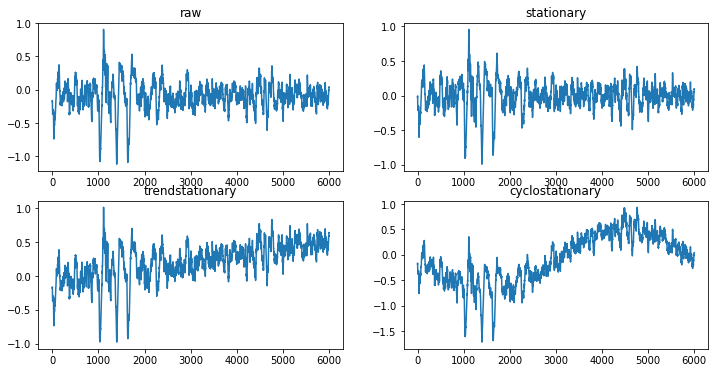

In [15]:
import matplotlib.pyplot as plt

sequence_length = 6000
t = np.linspace(0,sequence_length,sequence_length)
plt.figure(figsize =(12, 6))
label = ['S1_raw','S2_raw','S1_stationary','S2_stationary',
         'S1_trendstationary','S2_trendstationary','S1_cyclostationary','S2_cyclostationary']


label = ['raw','stationary','trendstationary','cyclostationary']


for i in range(4):
  k = x[i*4]
  print(y[i*4])
  plt.subplot(2, 2, i+1)
  plt.plot(t,k)
  plt.title(label[i])

We use only 1000 samples from each dataset

In [16]:
SC_list = glob.glob('/content/drive/MyDrive/sleep_edfx/Preprocessed_EEG/SC/**')
print(len(SC_list))
sleepedf_list = []
for i in range(2): #len(SC_list) 
  length = len(sleepedf_list)
  sleepedf_list.extend(glob.glob(SC_list[i]+'/**'))
  print(len(sleepedf_list) - length)
len(sleepedf_list)

153
2650
2830


5480

In [17]:
SS1_list = glob.glob('/content/drive/MyDrive/EEG_data/MASS/SS1/Preprocessed_EEGedf/**')
print(len(SS1_list))
MASS_list = []
for i in range(7,14):
    length = len(MASS_list)
    MASS_list.extend(glob.glob(SS1_list[i]+'/**'))
    print(len(MASS_list) - length)
print(len(MASS_list))

53
1004
1071
937
1041
1079
991
877
7000


In [18]:
data_dic = {'MASS' : MASS_list[:1000], 'Sleep_edf': sleepedf_list[:1000]}

In [19]:
train_dataset, val_dataset, test_dataset = concat_dataset(data_dic, seq_len = 6000).call()

MASS
split done
MASS train done
MASS val done
MASS test done
Sleep_edf
split done
sleep train done
sleep val done
sleep test done


In [20]:
from torch.utils.data import DataLoader
trainLoader = DataLoader(train_dataset, batch_size = 4 , shuffle= False)

In [21]:
import time
start_T = time.time()
for batch_idx, batch in enumerate(trainLoader):
  print('batch_idx:',batch_idx,' ',batch.shape)
  end_T = time.time()
  print('time:', end_T - start_T)
  if batch_idx >= 10:
        break

batch_idx: 0   torch.Size([4, 2, 6000])
time: 0.2806715965270996
batch_idx: 1   torch.Size([4, 2, 6000])
time: 0.2917594909667969
batch_idx: 2   torch.Size([4, 2, 6000])
time: 0.30333852767944336
batch_idx: 3   torch.Size([4, 2, 6000])
time: 0.31403326988220215
batch_idx: 4   torch.Size([4, 2, 6000])
time: 0.3271322250366211
batch_idx: 5   torch.Size([4, 2, 6000])
time: 0.33782172203063965
batch_idx: 6   torch.Size([4, 2, 6000])
time: 0.35083723068237305
batch_idx: 7   torch.Size([4, 2, 6000])
time: 0.36209750175476074
batch_idx: 8   torch.Size([4, 2, 6000])
time: 0.37464141845703125
batch_idx: 9   torch.Size([4, 2, 6000])
time: 0.3855319023132324
batch_idx: 10   torch.Size([4, 2, 6000])
time: 0.3963963985443115


In [22]:
class Temporal_Trend_Identification_Task_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, device = None):
        super().__init__()
        self.device = device

    def forward(self, batch, encoder, train):
        acc = 0
        x, y = augmented_data(batch,window = 200, a= 0.6, b = 0, c = 0.6, d= 1.5)
        c,t = x.shape
        x = np.reshape(x,(c,1,t))
        CrossEL = torch.nn.CrossEntropyLoss()
        pred = encoder.forward(torch.Tensor(x).to(device))
        y = torch.Tensor(y).to(device)
        _, y =  torch.max(y, 1) 
        
      
        # print('y:',y.shape)
        # print('rept:',rept.shape)
        loss = CrossEL(pred, torch.Tensor(y).to(device))
        if train:
            loss.backward(retain_graph=True)

        _, predicted = torch.max(pred, 1) 
        # print(predicted.shape)
        # print(y.shape)
        acc = (predicted == y).sum().item()
        acc = acc/c #acc/(batch*channels*4(augmented))
        loss = loss
        del x
        del y
        return loss, acc


In [23]:
import torch
import torch.nn as nn



class feature_extractor3(nn.Module):
    def __init__(self, seq_len):
        super(feature_extractor3,self).__init__()
        self.channels = 1 # we use only single channel 
        
        # Activation functions
        self.activation = nn.LeakyReLU()
        # self.bn = nn.BatchNorm1d(1)

        # self.conv2t = nns.SeparableConv1d(16,32,10,padding ='same') (in_channels, out_channels, kernel size,,,) 

        self.softmax = nn.Softmax()
        self.conv1t = nn.Conv1d(1,10, 30, padding ='same') #in_channels, out_channels, kernel_size, 
        self.conv1s = nn.Conv1d(10,10,self.channels)
        self.conv2t = nn.Conv1d(10,20,15,padding ='same') 
        self.conv2s = nn.Conv1d(20,20,self.channels)
        self.conv3t = nn.Conv1d(20,34,5,padding ='same')
        self.conv3s = nn.Conv1d(34,34,self.channels)
        
                  
        # Flatteninig
        self.flatten = nn.Flatten()

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Decision making
        self.Linear = nn.Linear(int(64*seq_len) ,4) # 

        # xavier initialization
        torch.nn.init.xavier_uniform_(self.conv1t.weight)
        torch.nn.init.xavier_uniform_(self.conv2t.weight)
        torch.nn.init.xavier_uniform_(self.conv3t.weight)
        torch.nn.init.xavier_uniform_(self.conv1s.weight)
        torch.nn.init.xavier_uniform_(self.conv2s.weight)
        torch.nn.init.xavier_uniform_(self.conv3s.weight)

      
    def embedding(self, x):
        x = self.activation(self.conv1t(x))
        f1 = self.activation(self.conv1s(x))

        x = self.activation(self.conv2t(x))
        f2 = self.activation(self.conv2s(x))

        x = self.activation(self.conv3t(x))
        f3 = self.activation(self.conv3s(x))
        
        # multi-scale feature representation by exploiting intermediate features
        feature = torch.cat([f1, f2, f3],dim = 1 )
        
        return feature

    def classifier(self, feature):
        # Flattening, dropout, mapping into the decision nodes
        feature = self.flatten(feature)
        feature = self.dropout(feature)
        y_hat = self.softmax(self.Linear(feature))
        return y_hat    

    def forward(self, x):
        feature = self.embedding(x)
        y_hat = self.classifier(feature)
        return y_hat

In [24]:
import os
import torch
# batch size
batch_size = 4
learning_rate = 0.0001
epochs = 20

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#"cpu"

In [25]:
print(device)

cuda:0


In [26]:

# dataset loader

trainLoader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False)
valLoader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False)
testLoader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [27]:
model = feature_extractor3(6000).to(device)
#model.to(device)
criterion = Temporal_Trend_Identification_Task_Loss(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [28]:
import matplotlib.pyplot as plt
loss_tr = []
loss_val = []
acc_tr = []
acc_val = []
for epoch in range(epochs):
    loss_ep = 0  # add batch loss in epoch
    acc_ep = 0
    for batch_idx, batch in enumerate(trainLoader):
        # print(batch.shape)
        optimizer.zero_grad()
        loss_batch, acc_batch = criterion.forward(batch, model, train = True)
        # print(batch_idx)
        optimizer.step()
        loss_ep += loss_batch.item()
        acc_ep += acc_batch

    loss_tr.append((loss_ep)/len(trainLoader))
    acc_tr.append((acc_ep)/len(trainLoader))

    loss_ep_val = 0
    acc_ep_val = 0
    for batch_idx, batch in enumerate(valLoader):
        loss_batch_val, acc_batch_val = criterion.forward(batch, model, train = False)
        loss_ep_val += loss_batch_val.item()
        acc_ep_val += acc_batch_val
    
    loss_val.append((loss_ep_val)/len(valLoader))
    acc_val.append((acc_ep_val)/len(valLoader))
    print("epoch : ", epoch, "  train loss : ", loss_tr[epoch], 'train acc : ', acc_tr[epoch], "    val loss : ", loss_val[epoch], 'val acc : ', acc_val[epoch])
    torch.save(model,'Temporal_2s_ep' + str(epoch)+'_.pt')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  self.padding, self.dilation, self.groups)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch :  0   train loss :  0.9396293582518895 train acc :  0.8150810185185184     val loss :  0.9071115988492966 val acc :  0.8437731481481489
epoch :  1   train loss :  0.9040893836816152 train acc :  0.8419907407407404     val loss :  0.9119918924570084 val acc :  0.8405555555555557
epoch :  2   train loss :  0.8950427651405335 train acc :  0.8496296296296292     val loss :  0.9005995148420334 val acc :  0.8467361111111111
epoch :  3   train loss :  0.879507272640864 train acc :  0.8654050925925924     val loss :  0.8869599030415217 val acc :  0.860844907407407
epoch :  4   train loss :  0.8767128753662109 train acc :  0.8682175925925926     val loss :  0.8936251278718312 val acc :  0.8556597222222221
epoch :  5   train loss :  0.8786069083213807 train acc :  0.8662037037037033     val loss :  0.8963630890846253 val acc :  0.8522106481481473
epoch :  6   train loss :  0.8690101357301077 train acc :  0.8755208333333325     val loss :  0.8939230632781983 val acc :  0.8534374999999993
e

result save and plot

In [29]:
import pandas as pd
col = ['loss_tr','loss_val','acc_tr','acc_val']
data = np.array([loss_tr,
                 loss_val,
                 acc_tr,
                 acc_val])
print(data.shape)
data = np.transpose(data)
df = pd.DataFrame(data = data, columns= col)
df.to_excel('1026_Sleepedf+MASS_30s.xlsx', index = False)

(4, 20)


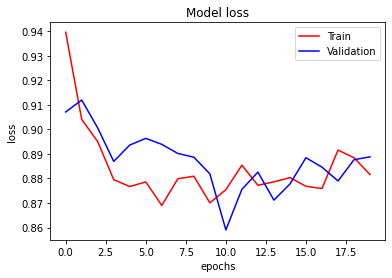

In [31]:
# plt.figure(figsize =(15, 10))
plt.plot(range(epochs), loss_tr, color='red')
plt.plot(range(epochs), loss_val, color='blue')
plt.title('Model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('1026_Sleepedf+MASS_loss_30s',bbox_inches = 'tight')
plt.show()


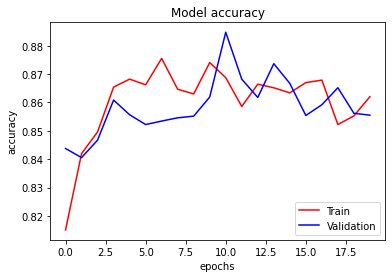

In [33]:
# plt.figure(figsize =(15, 10))
plt.plot(range(epochs), acc_tr, color='red')
plt.plot(range(epochs), acc_val, color='blue')
plt.title('Model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig('1026_Sleepedf+MASS_accuracy_30s',bbox_inches = 'tight')
plt.show()

In [34]:
torch.cuda.empty_cache() # GPU 캐시 데이터 삭제

In [35]:
def predict( batch, encoder):
  x, y = augmented_data(batch,window = 100 , a= 0.6, b = 0, c = 0.6, d= 1.5)
  c,t = x.shape
  # print('bj',x.shape)
  x = np.reshape(x,(c,1,t))
      
  rept = encoder.forward(torch.Tensor(x).to(device))
  
  rept = rept.cpu().detach().numpy()
  
  return rept, y

In [36]:
Y_hat = []
Y = []
for batch_idx, batch in enumerate(testLoader):
  y_hat,y = predict(batch, encoder = model)

  Y_hat.extend(y_hat)
  Y.extend(y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [37]:
Y_hat = np.array(Y_hat)
print(Y_hat.shape)

Y = np.array(Y)
print(Y.shape)

(16000, 4)
(16000, 4)


In [38]:
y_hat

array([[1.0000000e+00, 2.7427210e-35, 1.1312237e-35, 8.9235670e-34],
       [1.0000000e+00, 2.8586489e-43, 4.7630089e-36, 7.2675357e-38],
       [1.0000000e+00, 9.8627818e-16, 6.2379944e-21, 5.0069041e-21],
       ...,
       [0.0000000e+00, 0.0000000e+00, 1.5896089e-33, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 2.1261619e-37, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 4.7784278e-43, 1.0000000e+00]],
      dtype=float32)

In [39]:
Y_tensor = torch.Tensor(Y)
_, Y_tensor =  torch.max(Y_tensor, 1) 
Y_hat_tensor = torch.Tensor(Y_hat)


_, predicted = torch.max(Y_hat_tensor, 1) 
# print(predicted.shape)
# print(y.shape)
print(predicted.shape)
correct = (predicted == Y_tensor).sum().item()
wrong = len(Y) - correct

torch.Size([16000])


In [40]:
print(Y_tensor)
print(predicted)

tensor([0, 0, 0,  ..., 3, 3, 3])
tensor([0, 0, 0,  ..., 3, 3, 3])


In [41]:
correct, wrong

(13941, 2059)

In [42]:
print('accuracy:',correct/(correct + wrong))

accuracy: 0.8713125


In [43]:
# confusion matrix 사용을 위한 라이브러리
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_tensor, predicted)
print(conf_matrix)



[[3854  138    8    0]
 [   1 3999    0    0]
 [1908    1 2088    3]
 [   0    0    0 4000]]


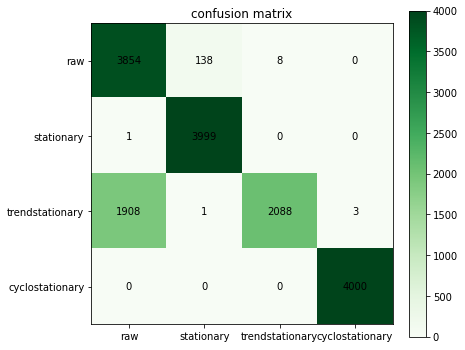

In [44]:
#one-hot encoding
      # original = [1,0,0,0]
      # s_maf = [0,1,0,0]
      # s_asln = [0,0,1,0]
      # s_apn = [0,0,0,1]

title = 'confusion matrix'
cmap=plt.cm.Greens
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)  # , cmap=plt.cm.Greens
plt.title(title, size=12)
plt.colorbar(fraction=0.05, pad=0.05)
tick_marks = np.arange(4, 4)
plt.xticks(np.arange(4), ('raw','stationary','trendstationary','cyclostationary'))
plt.yticks(np.arange(4), ('raw','stationary','trendstationary','cyclostationary'))


fmt = 'd' 
thresh = 1
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 ha="center", va="center", color="black" if conf_matrix[i, j] > thresh else "black")  #horizontalalignment

plt.savefig('1026_Sleepedf+MASS_confusionmatrix_5s',bbox_inches = 'tight')
